# Portfolio Risk Management and Prediction
Building a model to assess the risk of a financial portfolio and predict the potential return. This project will demonstrate skills in feature engineering, data imputation, model evaluation, and hyperparameter tuningby working wih historical stock data to simulate portfolio allocation and forecast risk-adjusted returns.

In [1]:
# pip install scikit-learn

## Import Librariries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

## Data Collection and Preprocessing/Cleaning
- Downloading stock data using ```yfinance```
- Checking for null values and dealeting rows where all values are null
- Adding Daily Returns, Variance and Volatility to the DataFrame

In [3]:
# List the stocks
stocks = ['AAPL', 'MSFT', 'AMD', 'GOOG', 'NVDA']
df = yf.download(stocks,
                 start='2014-01-01',
                 end='2024-11-01')

[*********************100%***********************]  5 of 5 completed


In [4]:
data = df['Adj Close']
data.head()

Ticker,AAPL,AMD,GOOG,MSFT,NVDA
Date,,,,,
2014-01-02 00:00:00+00:00,17.234293,3.95,27.656164,31.120735,0.373992
2014-01-03 00:00:00+00:00,16.855728,4.00,27.454418,30.911373,0.369512
2014-01-06 00:00:00+00:00,16.947651,4.13,27.760517,30.258121,0.374464
2014-01-07 00:00:00+00:00,16.826441,4.18,28.295689,30.492624,0.380595
2014-01-08 00:00:00+00:00,16.933002,4.18,28.354576,29.948265,0.385782


In [5]:
# Checking for null values
df.isnull().sum()
# If null:
# data = data.dropna(how='all')  # Drop rows where all ticker values are missing

Price      Ticker
Adj Close  AAPL      0
           AMD       0
           GOOG      0
           MSFT      0
           NVDA      0
Close      AAPL      0
           AMD       0
           GOOG      0
           MSFT      0
           NVDA      0
High       AAPL      0
           AMD       0
           GOOG      0
           MSFT      0
           NVDA      0
Low        AAPL      0
           AMD       0
           GOOG      0
           MSFT      0
           NVDA      0
Open       AAPL      0
           AMD       0
           GOOG      0
           MSFT      0
           NVDA      0
Volume     AAPL      0
           AMD       0
           GOOG      0
           MSFT      0
           NVDA      0
dtype: int64

## Feature Engineering

### Creating/Engineering the new features
- First scaling and imputing any missing values
- Calculating rolling average returns, rolling volatility and the sharpe ratio
- Combining all features into a single DataFrame and dropping rows with missing values

<b>Creating the target variable:</b>
- Setting the risk threshold using beta coefficients: A beta coefficient of less than 1 means that a stock tends to be less volatile than the overall market. A beta coefficient of more than 1 means that a stock tends to be more volatile than the overall market.
> We will use the ```max``` function to find a day where a stock exceeded the risk threshold. It flags the portfolio as high-risk which is a more conservative measure, as it indicates that any high volatility could impact the portfolio’s stability.
> 
> The average could be calculated however, if the average volatility is high, it implies that the portfolio as a whole is exposed to more risk as oppossed to an individual stock.

In [6]:
# Calculate daily returns
daily_returns = df['Adj Close'].pct_change()

# Step 2: Data Preprocessing

# Handle missing values (if any)
imputer = SimpleImputer(strategy='mean')
daily_returns_imputed = pd.DataFrame(imputer.fit_transform(daily_returns), columns=daily_returns.columns, index=daily_returns.index)

# Scale features
scaler = StandardScaler()
daily_returns_scaled = pd.DataFrame(scaler.fit_transform(daily_returns_imputed), columns=daily_returns_imputed.columns, index=daily_returns_imputed.index)


In [7]:
daily_returns_imputed.head()

Ticker,AAPL,AMD,GOOG,MSFT,NVDA
Date,,,,,
2014-01-02 00:00:00+00:00,0.001100,0.001963,0.000826,0.001083,0.002592
2014-01-03 00:00:00+00:00,-0.021966,0.012658,-0.007295,-0.006727,-0.011980
2014-01-06 00:00:00+00:00,0.005454,0.032500,0.011149,-0.021133,0.013401
2014-01-07 00:00:00+00:00,-0.007152,0.012106,0.019278,0.007750,0.016373
2014-01-08 00:00:00+00:00,0.006333,0.000000,0.002081,-0.017852,0.013631


In [8]:
daily_returns_scaled.head()

Ticker,AAPL,AMD,GOOG,MSFT,NVDA
Date,,,,,
2014-01-02 00:00:00+00:00,-1.227585e-17,0.000000,0.000000,1.294669e-17,0.000000
2014-01-03 00:00:00+00:00,-1.305814e+00,0.295212,-0.463193,-4.663419e-01,-0.491129
2014-01-06 00:00:00+00:00,2.464561e-01,0.842909,0.588885,-1.326446e+00,0.364331
2014-01-07 00:00:00+00:00,-4.671728e-01,0.279982,1.052562,3.980524e-01,0.464476
2014-01-08 00:00:00+00:00,2.962458e-01,-0.054195,0.071623,-1.130557e+00,0.372065


In [9]:
# Define annual risk-free rate (e.g., 1% or 0.01) and divide by 252 trading days for the daily risk free rate
daily_risk_free_rate = 0.01 / 252

# Subtract daily risk-free rate from daily returns to adjust for the risk-free rate
adjusted_daily_returns = daily_returns_scaled - daily_risk_free_rate

In [10]:
# Calculate 20 day average returns
rolling_avg_returns = adjusted_daily_returns.rolling(window=20).mean()

# Calculating Volatility
rolling_volatility = daily_returns_scaled.rolling(window=20, min_periods=1).std()

# Calculate the Sharpe Ratio assuming risk-free return is zero for simplicity
sharpe_ratio = adjusted_daily_returns / rolling_volatility

In [11]:
# Add all features to the dataframe
features = pd.concat([rolling_avg_returns.add_suffix('_avg_return'), 
                      rolling_volatility.add_suffix('_volatility'), 
                      sharpe_ratio.add_suffix('_sharpe_ratio')], axis=1)

In [12]:
# Drop any rows with NaN values introduced by rolling calculations
features = features.dropna()

# Display first few rows of features DataFrame
features.head()

Ticker,AAPL_avg_return,AMD_avg_return,GOOG_avg_return,MSFT_avg_return,NVDA_avg_return,AAPL_volatility,AMD_volatility,GOOG_volatility,MSFT_volatility,NVDA_volatility,AAPL_sharpe_ratio,AMD_sharpe_ratio,GOOG_sharpe_ratio,MSFT_sharpe_ratio,NVDA_sharpe_ratio
Date,,,,,,,,,,,,,,,
2014-01-30 00:00:00+00:00,-0.332301,-0.207306,0.017566,-0.078772,-0.093704,1.236595,1.016431,0.835235,0.931208,0.549380,-0.139086,-0.053358,1.700087,0.280325,0.872660
2014-01-31 00:00:00+00:00,-0.330771,-0.229846,0.129707,-0.002634,-0.100216,1.237047,1.016591,0.972097,0.997851,0.548983,0.024707,-0.443474,2.307158,1.525995,-0.237307
2014-02-03 00:00:00+00:00,-0.263336,-0.287554,0.035702,-0.089846,-0.102569,1.217704,1.017977,1.113129,1.110393,0.550845,0.035197,-0.843823,-2.105170,-1.990850,-0.977100
2014-02-04 00:00:00+00:00,-0.237797,-0.315831,0.015806,-0.037395,-0.115362,1.234202,0.992459,1.106256,1.073052,0.542337,0.613508,0.279442,0.172577,-0.258576,0.199928
2014-02-05 00:00:00+00:00,-0.196411,-0.357112,-0.026547,-0.104059,-0.158096,1.239969,0.983504,1.080389,1.085917,0.527723,0.290729,-0.554838,0.190173,-0.861271,-0.739508


In [13]:
# Create a binary target for risk classification (high-risk (1) vs low-risk (0))
# Here we define high-risk days as those with volatility exceeding a certain threshold (e.g., 1.5 std dev)
risk_threshold = 1.5
features['high_risk'] = np.where((features.filter(like='_volatility').max(axis=1) > risk_threshold),1,0)

# Preview the resulting features DataFrame
features.head()

Ticker,AAPL_avg_return,AMD_avg_return,GOOG_avg_return,MSFT_avg_return,NVDA_avg_return,AAPL_volatility,AMD_volatility,GOOG_volatility,MSFT_volatility,NVDA_volatility,AAPL_sharpe_ratio,AMD_sharpe_ratio,GOOG_sharpe_ratio,MSFT_sharpe_ratio,NVDA_sharpe_ratio,high_risk
Date,,,,,,,,,,,,,,,,
2014-01-30 00:00:00+00:00,-0.332301,-0.207306,0.017566,-0.078772,-0.093704,1.236595,1.016431,0.835235,0.931208,0.549380,-0.139086,-0.053358,1.700087,0.280325,0.872660,0
2014-01-31 00:00:00+00:00,-0.330771,-0.229846,0.129707,-0.002634,-0.100216,1.237047,1.016591,0.972097,0.997851,0.548983,0.024707,-0.443474,2.307158,1.525995,-0.237307,0
2014-02-03 00:00:00+00:00,-0.263336,-0.287554,0.035702,-0.089846,-0.102569,1.217704,1.017977,1.113129,1.110393,0.550845,0.035197,-0.843823,-2.105170,-1.990850,-0.977100,0
2014-02-04 00:00:00+00:00,-0.237797,-0.315831,0.015806,-0.037395,-0.115362,1.234202,0.992459,1.106256,1.073052,0.542337,0.613508,0.279442,0.172577,-0.258576,0.199928,0
2014-02-05 00:00:00+00:00,-0.196411,-0.357112,-0.026547,-0.104059,-0.158096,1.239969,0.983504,1.080389,1.085917,0.527723,0.290729,-0.554838,0.190173,-0.861271,-0.739508,0


In [14]:
# Checking how many days a stock was volatile/high-risk
features['high_risk'].value_counts()

high_risk
0    2109
1     599
Name: count, dtype: int64

## Model Building

- Train multiple classification models (e.g., logistic regression, random forest, KNN) to predict high-risk vs. low-risk days.
- Use Pipeline to include scaling and model fitting in one workflow.
- Perform GridSearchCV to find the best parameters for the primary model.

In [15]:
# Define variables
X = features.drop('high_risk', axis=1)
y = features['high_risk']

In [16]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Building the pipeline

In [17]:
# Define models and their seperate hyperparameter grids
# Dictionary Structure: model name, the ML model and the parameters

models_and_params = {
    'KNN': (KNeighborsClassifier(), {
        'model__n_neighbors': np.arange(1, 10),
        'model__metric': ['euclidean', 'manhattan']
    }),
    'Logistic Regression': (LogisticRegression(max_iter=1000), {
        'model__C': np.logspace(-4, 4, 10),
        'model__penalty': ['l2']
    }),
    'Random Forest': (RandomForestClassifier(random_state=42), {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 10, 20, 30]
    })
}

In [18]:
# Cross Validation setup and store pipeline results
kf = KFold(n_splits=5, shuffle=True, random_state=42)
pipeline_results = {}

# Loop through models and perform cross-validation with hyperparameter tuning
for model_name, (model, param_grid) in models_and_params.items():
    # Create a pipeline with scaling and the model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=kf, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Store and print results for each model
    pipeline_results[model_name] = {
        'Best Parameters': grid_search.best_params_,
        'Best Cross-Validation Score': grid_search.best_score_,
        'Best Estimator': grid_search.best_estimator_
    }
    
    print(f"{model_name} Best Parameters: {grid_search.best_params_}")
    print(f"{model_name} Best Cross-Validation Score: {grid_search.best_score_:.4f}")
    print(f"{model_name} Best Estimator: {grid_search.best_estimator_}")

KNN Best Parameters: {'model__metric': 'manhattan', 'model__n_neighbors': np.int64(1)}
KNN Best Cross-Validation Score: 0.9608
KNN Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 KNeighborsClassifier(metric='manhattan',
                                      n_neighbors=np.int64(1)))])
Logistic Regression Best Parameters: {'model__C': np.float64(2.782559402207126), 'model__penalty': 'l2'}
Logistic Regression Best Cross-Validation Score: 0.9211
Logistic Regression Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(C=np.float64(2.782559402207126),
                                    max_iter=1000))])
Random Forest Best Parameters: {'model__max_depth': None, 'model__n_estimators': 200}
Random Forest Best Cross-Validation Score: 0.9968
Random Forest Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomFore

In [19]:
# Display summary of results
print("Summary of Cross-Validation Results:")
results_df = pd.DataFrame(pipeline_results).T
results_df

Summary of Cross-Validation Results:


,Best Parameters,Best Cross-Validation Score,Best Estimator
KNN,"{'model__metric': 'manhattan', 'model__n_neigh...",0.960762,"(StandardScaler(), KNeighborsClassifier(metric..."
Logistic Regression,"{'model__C': 2.782559402207126, 'model__penalt...",0.921052,"(StandardScaler(), LogisticRegression(C=np.flo..."
Random Forest,"{'model__max_depth': None, 'model__n_estimator...",0.996768,"(StandardScaler(), (DecisionTreeClassifier(max..."


<b>Summary of results:</b> The Random Forest model is the best model with a cross-validation score of 99.68% (to 2 d.p.), suggesting it will predict whether a portfolio is high-risk with 99.68% accuracy. Additionally, the best parameters for this model are a maximum depth of None (unrestricted) and 200 decision trees.

In [20]:
print(pipeline_results[model_name]['Best Estimator'])

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(n_estimators=200, random_state=42))])


## Evaluation and Intepretation

### Calculating ROC and AUC
- ROC: (Receiver operating characteristic) a graphical plot that illustrates the performance of a binary classifier model. A curve higher to 1 at the y-axis is the optimum outcome
- AUC: A numerical value that represents the overall performance of a classification model where a higher AUC generally indicates a better-performing model.
>Interpretation:
>0.5: Random guessing.
>1.0: Perfect classification.

In [23]:
# Scaling features
scaler.fit(features)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


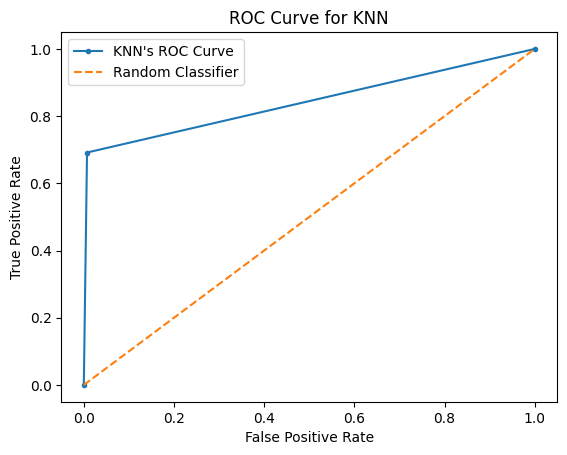

AUC Score: 0.84


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


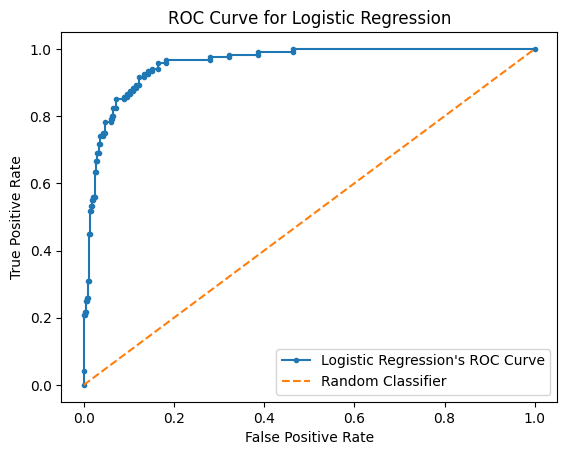

AUC Score: 0.96


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


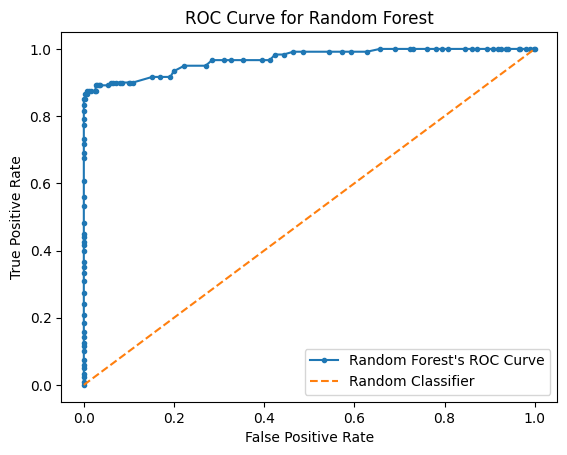

AUC Score: 0.97


In [24]:
for model_name, (model, params) in models_and_params.items():
    
    # Use the best estimator found in GridSearchCV for each model
    best_model = pipeline_results[model_name]['Best Estimator']

    # Predict probabilities for the positive class
    y_pred_probs = best_model.predict_proba(X_test_scaled)[:, 1] 

    # Calculate FPR, TPR, and thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
 
    # Plot ROC curve
    plt.plot(fpr, tpr, marker='.', label=f"{model_name}'s ROC Curve")
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc='best')
    plt.show()
    
    # Calculate AUC score
    auc_score = roc_auc_score(y_test, y_pred_probs)
    print(f"AUC Score: {auc_score:.2f}")

### Calculating accuracy

In [25]:
# Choose the best model based on cross-validation results (i.e. Random Forest)
best_model = RandomForestClassifier(random_state=42)
acc_pipeline = Pipeline([
    ('scaler', scaler),
    ('classifier', best_model)
])

# Fit on the training data and evaluate on the test set
acc_pipeline.fit(X_train, y_train)
y_pred = acc_pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9945


The Random Forest model emerged as the top-performing model with a cross-validation score of 0.9968, indicating high predictive accuracy. The optimal hyperparameters for this model were an unrestricted maximum depth and 200 decision trees. Further analysis revealed an AUC of 0.97 and an accuracy score of 0.9945, confirming the model's strong performance.

## Results

### Plotting Predicted and Actual Risk Over Time with Random Forest 

In [26]:
# Assuming y_test has an index with dates and hadnling the index if it doesn't
dates = y_test.index if isinstance(y_test, pd.Series) else pd.Series(y_test).index

# Generate predicted risk probabilities and labels
best_model = pipeline_results['Random Forest']['Best Estimator']

# Classify as high risk if probability >= 0.5
y_pred_labels = (y_pred_probs >= 0.5).astype(int)  

# Prepare data for plotting by creating a DataFrame
plot_data = pd.DataFrame({
    'Date': dates,
    'Actual Risk': y_test.values,       # Actual high-risk (1 or 0)
    'Predicted Risk': y_pred_labels        # Predicted high-risk (1 or 0)
})
plot_data.set_index('Date', inplace=True)
# Display dataframe
plot_data.head()

,Actual Risk,Predicted Risk
Date,,
2023-12-04 00:00:00+00:00,0,0
2023-03-23 00:00:00+00:00,0,0
2022-09-15 00:00:00+00:00,0,0
2018-09-17 00:00:00+00:00,0,0
2017-11-27 00:00:00+00:00,0,0


In [27]:
print(plot_data['Actual Risk'].value_counts())
print(plot_data['Predicted Risk'].value_counts())

Actual Risk
0    422
1    120
Name: count, dtype: int64
Predicted Risk
0    437
1    105
Name: count, dtype: int64


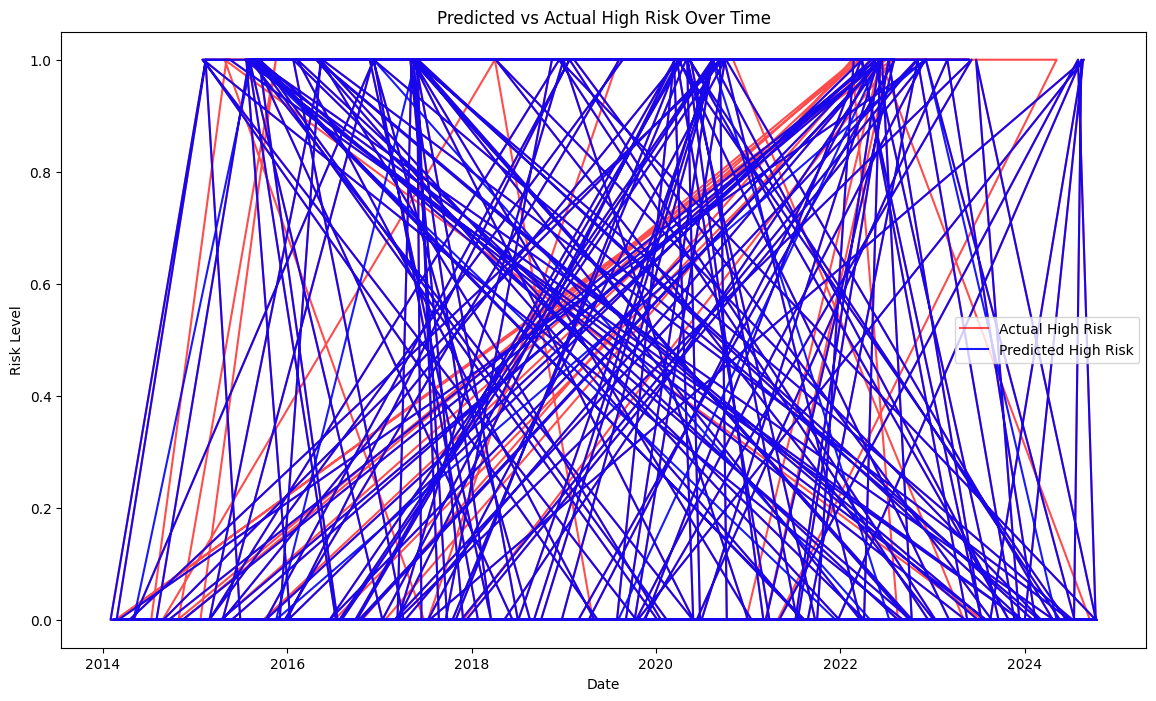

In [28]:
# Plot predicted and actual risk over time
plt.figure(figsize=(14, 8))

# Plot Actual Risk
plt.plot(plot_data.index, plot_data['Actual Risk'], label='Actual High Risk', color='red', alpha=0.7)

# Plot predicted risk 
plt.plot(plot_data.index, plot_data['Predicted Risk'], label='Predicted High Risk', color='blue', alpha=0.9)

plt.title('Predicted vs Actual High Risk Over Time')
plt.xlabel('Date')
plt.ylabel('Risk Level')
plt.legend(loc='best')
plt.show()

# Conclusion:
Regarding the <b><i>"Predicted vs Actual High Risk Over Time" graph</i></b>, the closer the blue lines are to the red lines, the more accurate the model's predictions. If the lines overlap, it means the model is correctly identifying high-risk portfolios.

The Random Forest model emerged as the top-performing model with a cross-validation score of 0.9968, indicating high predictive accuracy. The optimal hyperparameters for this model were an unrestricted maximum depth and 200 decision trees. Further analysis revealed an AUC of 0.97 and an accuracy score of 0.9945, confirming the model's strong performance.